# CMS Anomaly Detection

## Prepearing data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

import re

DATA_PATH = 'merged.pickle'

The input files contains preselected features from CMS 2010B open data.
The features were generated from original root in following way:

1. There were selected 3 streams:
  - MiniBias,
  - muons,
  - photons.
2. In each stream 4 "channels" were selected:
  - muons
  - photons
  - PF (particle flows)
  - calo (calorimiter)
3. For each channel from each event  5 quantile particles were selected with redards to thier momentum: quantile $q_i$ corresponds to particle with index closest to $\frac{i}{5}N$, i.e. $q_5$ corresponds to the particle with maximal momentum.
4. Each particle is described by its physical properties: $\eta, \phi, p_T, f_x, f_y, f_z, m$
5. Physical features were aggragated by lumisections, producing:
  - 1, 25, 50, 75, 99 percentiles
  - mean and std
  
As the result each lumisection is described by percentiles, means and stds of distributions of physical features of particles of particular quantiles within particular channel within particular stream.

Some additional features were added like total momentum of all particles of particular channel within event

In [2]:
import cPickle as pickle

with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

labels = np.load('labels.npy')

In [3]:
### technical columns
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

### columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

In [4]:
np.sum(np.isnan(data.values))

0

In [5]:
for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [6]:
np.sum(np.isnan(data.values))

0

In [7]:
data

,_instantLumi_minibias,_instantLumi_muons,_instantLumi_photons,_luminosityBlock,_run,minibias_PF_Px_mean,minibias_PF_Px_p1,minibias_PF_Px_p25,minibias_PF_Px_p50,minibias_PF_Px_p75,...,photons_photons_pt__q4_p75,photons_photons_pt__q4_p99,photons_photons_pt__q4_std,photons_photons_pt__q5_mean,photons_photons_pt__q5_p1,photons_photons_pt__q5_p25,photons_photons_pt__q5_p50,photons_photons_pt__q5_p75,photons_photons_pt__q5_p99,photons_photons_pt__q5_std
0,18.898952,18.897828,18.898925,712.0,149442.0,0.553982,0.121924,-2.377744,2.979489,3.999278,...,0.764066,0.771053,0.613178,0.671934,-0.115348,0.529921,0.626325,0.669504,0.781640,0.624168
1,18.867998,18.868584,18.869070,715.0,149442.0,0.618719,0.140093,-2.245878,3.164899,4.423358,...,0.816295,1.448301,0.720708,0.596897,-0.115348,0.500126,0.613411,0.762044,0.373972,0.564393
2,18.883743,18.884106,18.883098,713.0,149442.0,0.590468,0.089144,-2.267943,3.180846,4.379818,...,1.024795,0.315584,0.565043,0.521407,-0.115348,0.398654,0.593673,0.525674,1.095464,0.607292
3,18.871033,18.869170,18.871886,714.0,149442.0,0.563941,0.119073,-2.135948,3.271239,4.200118,...,1.010522,1.116072,0.778321,0.669518,-0.115348,0.659620,0.662089,0.603566,0.905891,0.494840
4,15.870896,15.871089,15.871073,1023.0,149442.0,0.512639,0.077763,-2.699199,2.974805,4.191212,...,0.864409,0.397704,0.620604,0.533768,-0.115348,0.444284,0.585253,0.609742,1.004260,0.574727
5,15.881587,15.881902,15.880656,1021.0,149442.0,0.517615,0.103767,-2.663293,2.657162,3.985256,...,0.648973,1.369331,0.777599,0.577041,-0.115348,0.526261,0.596193,0.478365,0.648295,0.346964
6,15.891679,15.891073,15.891229,1022.0,149442.0,0.563187,0.102591,-2.438237,2.993670,4.275795,...,0.919552,0.240982,0.398985,0.444162,-0.115348,0.329574,0.505470,0.449276,0.451287,0.421262
7,15.902432,15.902046,15.904499,1019.0,149442.0,0.505455,0.100209,-2.434321,3.207387,3.973735,...,0.938196,0.244517,0.423203,0.507372,-0.115348,0.346889,0.567593,0.525296,0.685222,0.375095
8,15.898545,15.900641,15.898303,1020.0,149442.0,0.574270,0.096662,-1.984827,3.611923,4.527441,...,0.944487,0.125781,0.404884,0.529739,-0.115348,0.443858,0.608706,0.572331,0.111104,0.021400
9,134.498240,134.497326,134.497602,891.0,148862.0,0.143227,0.193403,-1.220393,-0.248370,0.592133,...,0.895971,0.757568,0.771628,0.576278,-0.115348,0.400897,0.583197,0.597291,0.727995,0.536766


## Grouping features

Feature set has its own intristic hierarchy. It can be easily seen from their names:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

We are going to build hierarchical Artificial Neural Network, so firstly we must bring features into hierarchy.

In [8]:
### utility functions
def insert(keys, d, f):
    key = keys[0]

    if len(keys) == 1:
        d[key] = f
    else:
        if not d.has_key(key):
            d[key] = dict()
        return insert(keys[1:], d[key], f)

def levels(features, n_levels = 5):
    dicts = [features]

    levels = list()

    for level in range(n_levels):
        levels.append(
            set([ k for d in dicts for k in d ])
        )
    
        dicts = [ d[k] for d in dicts for k in d ]
    return levels
    
def get_feature_groups(feature_list, re_exp):
    """
    Retuns:
    1. hierachical dictionary feature groups -> feature full name
    2. feature levels
    3. unprocessed features
        
    """
    features = dict()
    rest = list()
    n_levels = set()

    for f in feature_list:
        matches = re.findall(re_exp, f)

        if len(matches) == 1:
            insert(matches[0], features, f)
            n_levels.add(len(matches[0]))
        elif len(matches) == 0:
            rest.append(f)
        else:
            raise Exception('Very suspicious feature: %s -> %s' % (f, matches))
    assert len(n_levels) == 1
    return features, levels(features, n_levels=list(n_levels)[0]), rest

In [9]:
def insert_fake_path(d, level, path = 'general'):
    if level == 0:
        return { path : d }
    else:
        r = dict()
        for k in d:
            r[k] = insert_fake_path(d[k], level - 1, path)
        
        return r

### Selecting particles' features:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

In [10]:
particle_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(q[12345])[_](\w+)')
particle_features, particle_levels, rest = get_feature_groups(features, particle_f_re)

In [11]:
for level in particle_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
phi pt fX fY fZ eta mass
q1 q3 q2 q5 q4
std p99 p1 p25 p75 p50 mean


### Selecting features that belong to a particle type:
> `<stream>_<particle type>_<physical feature>_<feature quantile>`

In [12]:
particle_type_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+([a-zA-Z0-9]+)')
particle_type_features, particle_type_levels, rest = get_feature_groups(rest, particle_type_f_re)

In [13]:
for level in particle_type_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
Pz Px Py
std p99 p1 p25 p75 p50 mean


In [14]:
particle_type_features = insert_fake_path(particle_type_features, level = 2, path='allParticles')

for level in levels(particle_type_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
allParticles
Pz Px Py
std p99 p1 p25 p75 p50 mean


The features above are components of momentum of particles of particular type (channel) within event.

### Selecting features specific to events:
> `<stream>_<physical feature>_<feature quantile>`

In [15]:
event_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(\w+)')
event_features, event_levels, rest = get_feature_groups(rest, event_f_re)

In [16]:
for level in event_levels:
    print ' '.join(list(level))

muons minibias photons
instantLumi
std p99 p1 p25 p75 p50 mean


In [17]:
f = insert_fake_path(event_features, level = 1, path='allChannels')
f = insert_fake_path(f, level = 2, path='allParticles')

event_features = f

for level in levels(event_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
allChannels
allParticles
instantLumi
std p99 p1 p25 p75 p50 mean


Which are instant luminosity of each event.

In [18]:
rest

['minibias_nEvents',
 'minibias_nonZeroWeights',
 'muons_nEvents',
 'muons_nonZeroWeights',
 'photons_nEvents',
 'photons_nonZeroWeights']

### And finally features specific to lumisection itself:
> `<stream>_<physical feature>_<feature quantile>`

In [19]:
stream_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)')
stream_features, stream_levels, rest = get_feature_groups(rest, stream_f_re)

In [20]:
for level in stream_levels:
    print ' '.join(list(level))

muons minibias photons
nEvents nonZeroWeights


Number of events and fration of non-zero features for lumisection (all NA's are replaced with zeros).

In [21]:
rest

[]

In [22]:
from collections import defaultdict

def flatten(a_dict):
    for k in a_dict:
        if hasattr(a_dict[k], 'keys'):
            for path, value in flatten(a_dict[k]):
                yield (k, ) + path, value
        else:
            yield (k, ), a_dict[k]

def merge(dicts):
    result = dict()
    for d in dicts:
        for path, value in flatten(d):
            insert(path, result, value)

    return result

def flatten_dict(d):
    r = dict()
    for paths, v in flatten(d):
        k = '_'.join(paths)
        r[k] = v
    return r

def squezze(d, depth = 5, last=2):
    dc = d.copy()

    if depth - 1 == last:
        for k in d:
            dc[k] = flatten_dict(d[k])
        
        return d
    else:
        for k in d:
            dc[k] = squezze(d[k], depth-1, last)
        
        return dc

def group(d, level=2):
    gd = defaultdict(lambda: list())
    for path, k in flatten(d):
        gk = '_'.join(path[:level])
        gd[gk].append(k)
    
    return gd

In [23]:
feature_hierarchy = merge([
    particle_features, particle_type_features, event_features
])

In [24]:
grouped = group(feature_hierarchy, level=2)

In [25]:
len(grouped)

15

In [26]:
[ (g, len(fs)) for g, fs in grouped.items() ]

[(u'photons_allChannels', 7),
 (u'minibias_photons', 231),
 (u'photons_PF', 126),
 (u'minibias_calo', 266),
 (u'photons_calo', 266),
 (u'minibias_PF', 126),
 (u'minibias_muons', 266),
 (u'muons_calo', 266),
 (u'muons_PF', 126),
 (u'muons_allChannels', 7),
 (u'minibias_allChannels', 7),
 (u'muons_muons', 266),
 (u'photons_muons', 266),
 (u'photons_photons', 231),
 (u'muons_photons', 231)]

## Building netwrok

In [27]:
%env THEANO_FLAGS='device=gpu0', 'floatX=float32'

import theano
import theano.tensor as T

from lasagne import *

import crayimage
from crayimage.nn import Expression

env: THEANO_FLAGS='device=gpu0', 'floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [28]:
class AE(Expression):
    def __init__(self, n_input_features, nums_units=(50, 10)):
        X_batch = T.fmatrix('X')
        self.input = layers.InputLayer(shape=(None, n_input_features), input_var=X_batch)
        
        net = self.input
        
        for n in nums_units:
            net = layers.DenseLayer(net, num_units=n, nonlinearity=nonlinearities.elu)
        
        code = layers.get_output(net)
        self.code_layer = net
        
        for n in nums_units[:-1][::-1]:
            net = layers.DenseLayer(net, num_units=n, nonlinearity=nonlinearities.elu)
        
        net = layers.DenseLayer(net, num_units=n_input_features, nonlinearity=nonlinearities.elu)
        self.net = net
        
        X_reconstructed = layers.get_output(net)
        self.X_reconstructed = X_reconstructed
        
        super(AE, self).__init__(self.input, self.net)
        
        reconstruction_error = T.sum((X_reconstructed - X_batch) ** 2, axis=1)
        mse_loss = T.mean(reconstruction_error)
        
        reg = regularization.regularize_network_params(net, regularization.l2)
        reg_C = T.fscalar('reg_c')
        
        loss = mse_loss + reg_C * reg
        
        learning_rate = T.fscalar('learning rate')
        params = layers.get_all_params(net)
        upd = updates.adadelta(loss, params, learning_rate=learning_rate)
        
        self.train = theano.function([X_batch, reg_C, learning_rate], mse_loss, updates=upd)
        self.get_error = theano.function([X_batch], reconstruction_error)
        self.encode = theano.function([X_batch], code)
        
        given_code = T.fmatrix('given code')
        X_decoded = layers.get_output(net, inputs={self.code_layer : given_code})
        self.decode = theano.function([given_code], X_decoded)
    
    @staticmethod
    def batch_stream(X, batch_size=32):
        indx = np.random.permutation(X.shape[0])
        n_batches = X.shape[0] / batch_size
        
        for i in xrange(n_batches):
            batch_indx = indx[(i * batch_size):(i * batch_size + batch_size)]
            yield X[batch_indx]
    
    def fit(self, X, n_epoches = 1, batch_size=32, learning_rate = 1.0, regularization_c = 1.0e-3):
        n_batches = X.shape[0] / batch_size
        
        learning_rate = np.float32(learning_rate)
        regularization_c = np.float32(regularization_c)
        
        losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
        for epoch in xrange(n_epoches):
            batch_stream = self.batch_stream(X, batch_size)
            
            for i, X_batch in enumerate(batch_stream):
                losses[epoch, i] = self.train(X_batch, regularization_c, learning_rate)
            
            yield losses[:(epoch + 1)]

In [49]:
import sklearn
from sklearn.mixture import BayesianGaussianMixture

Feature group photons_allChannels
Mean field estimation error: 6.08e+00
AE error: 7.34e-03


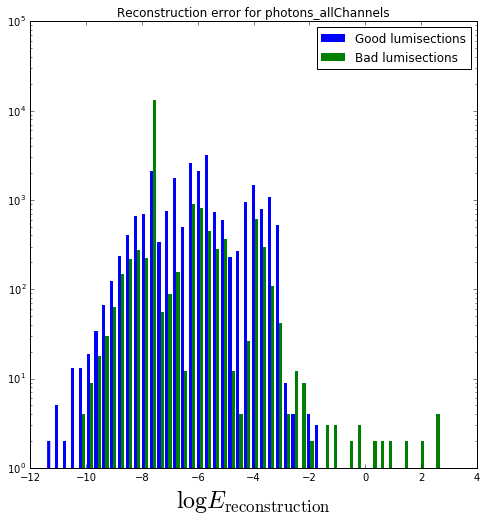

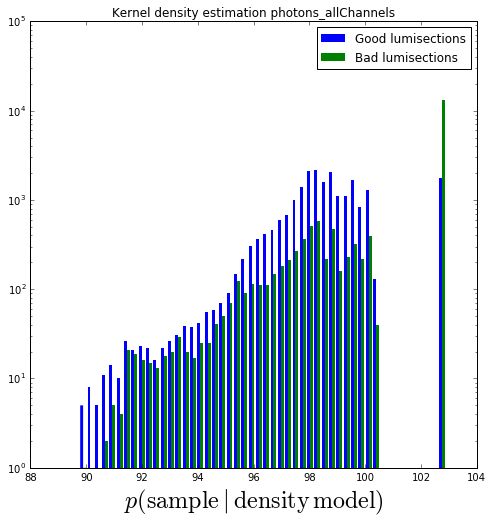

Feature group minibias_photons
Mean field estimation error: 7.23e+01
AE error: 6.59e+00


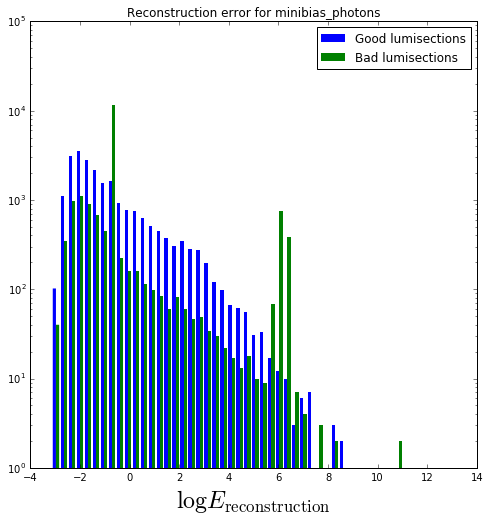

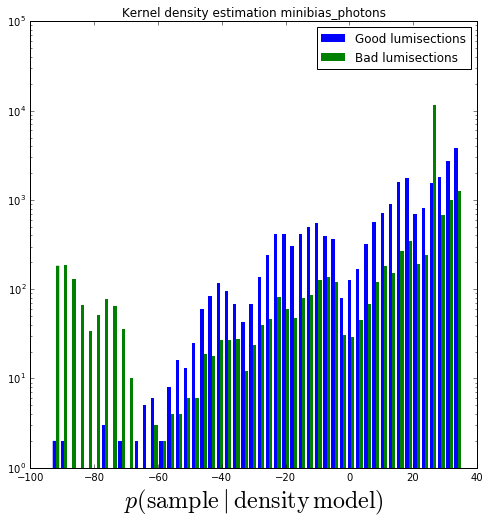

Feature group photons_PF
Mean field estimation error: 9.33e+00
AE error: 1.21e+00


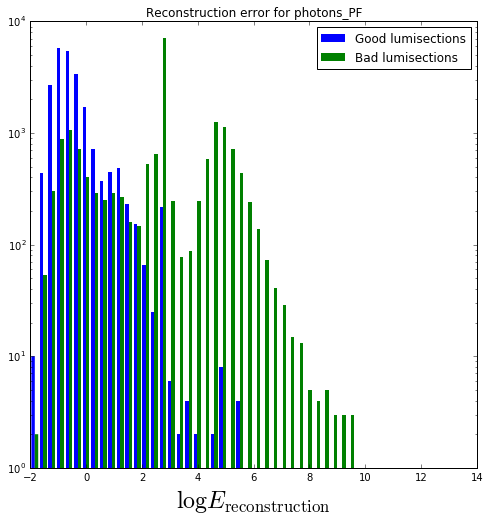

/home/mborisya/opt/miniconda/lib/python2.7/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 10 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


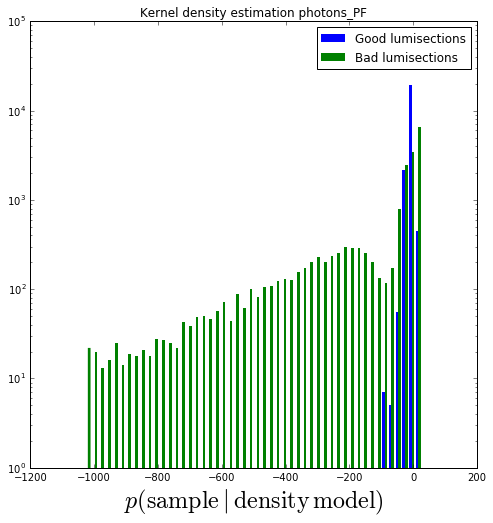

Feature group minibias_calo
Mean field estimation error: 6.20e+01
AE error: 7.92e+00


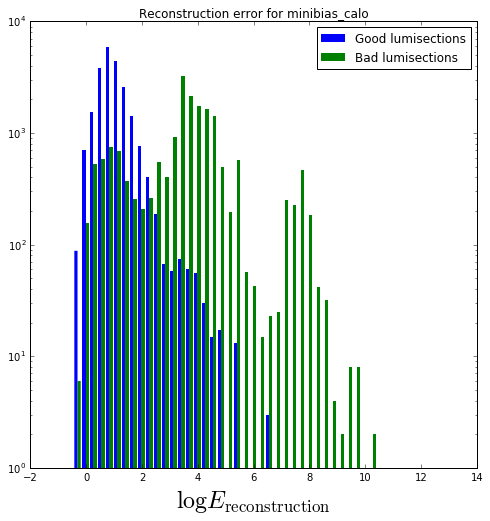

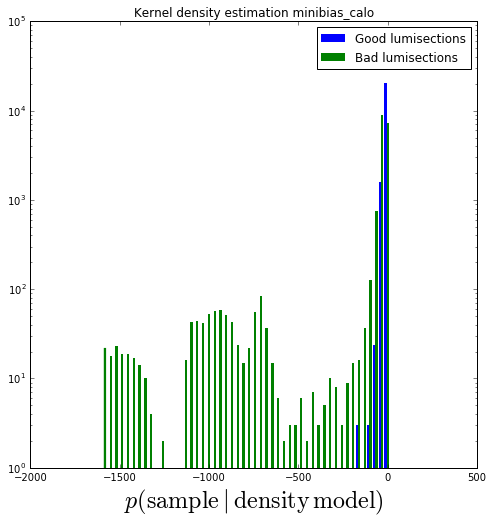

Feature group photons_calo
Mean field estimation error: 4.22e+01
AE error: 4.53e+00


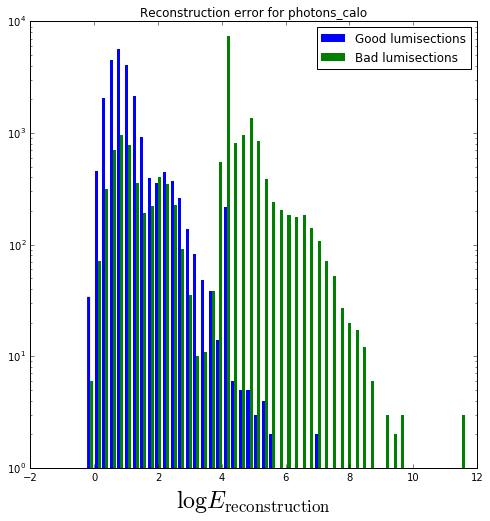

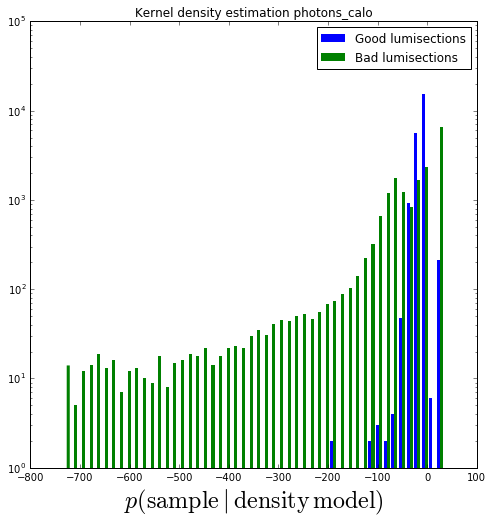

Feature group minibias_PF
Mean field estimation error: 3.63e+01
AE error: 4.65e+00


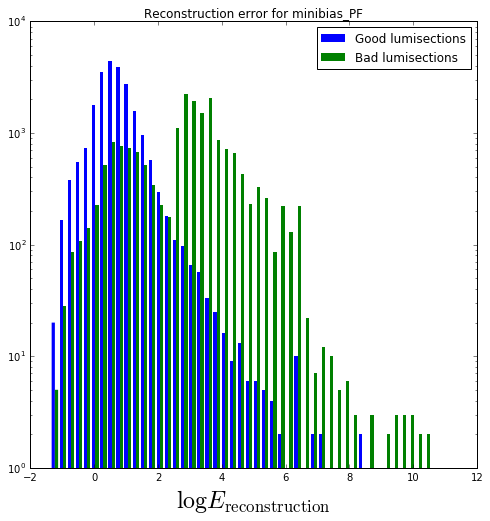

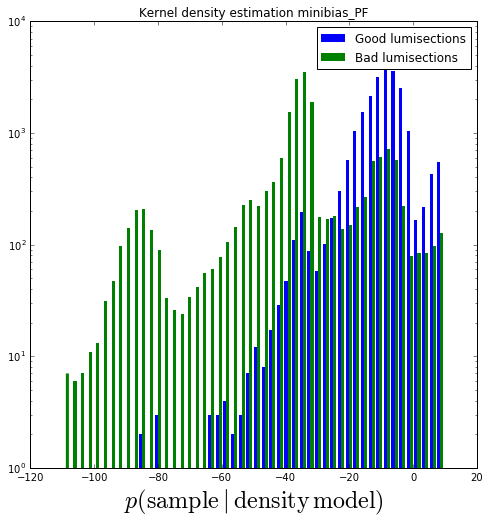

Feature group minibias_muons
Mean field estimation error: 7.37e+01
AE error: 1.49e+01


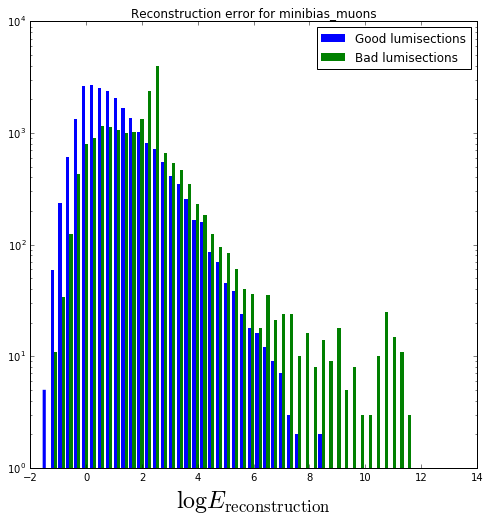

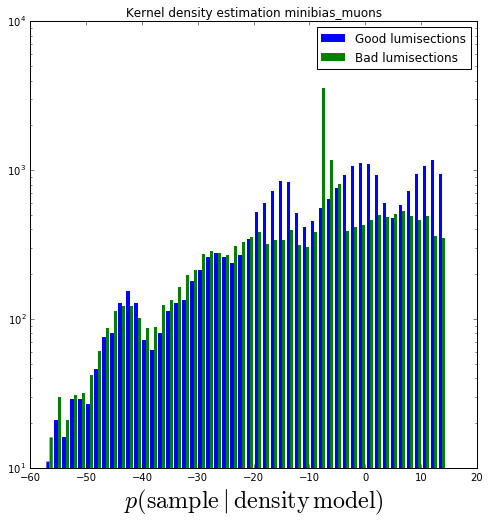

Feature group muons_calo
Mean field estimation error: 7.43e+01
AE error: 5.55e+00


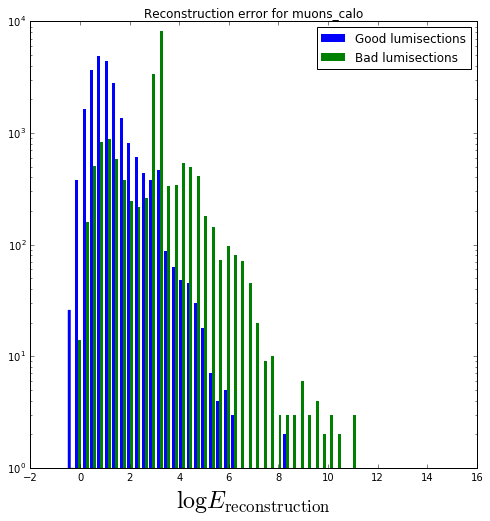

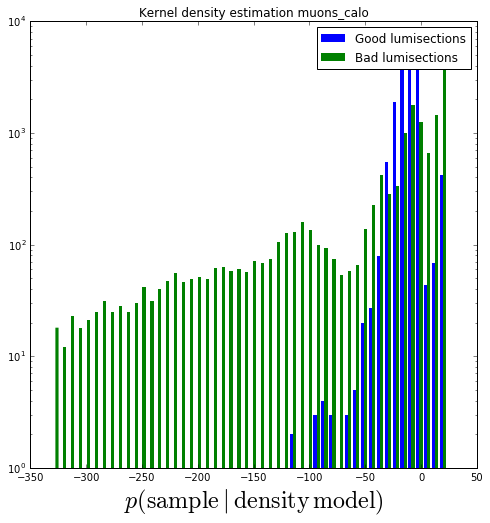

Feature group muons_PF
Mean field estimation error: 2.44e+01
AE error: 2.52e+00


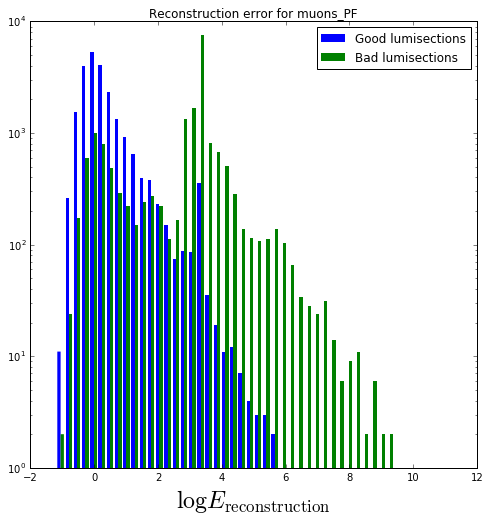

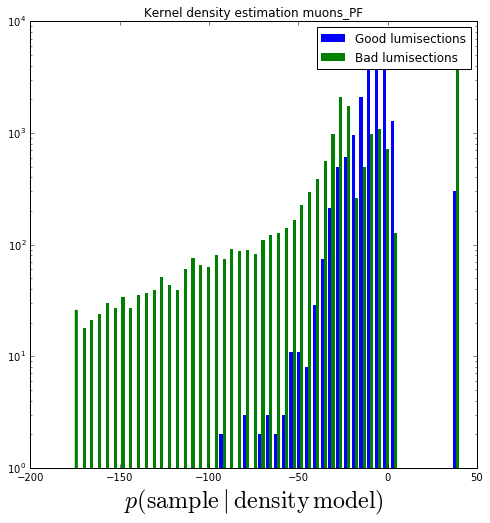

Feature group muons_allChannels
Mean field estimation error: 6.16e+00
AE error: 1.71e-03


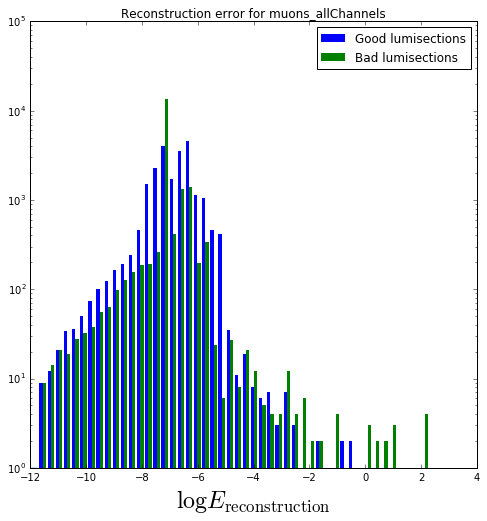

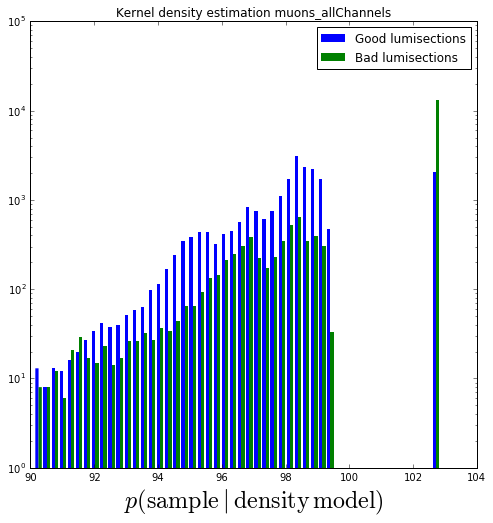

Feature group minibias_allChannels
Mean field estimation error: 6.16e+00
AE error: 1.66e-02


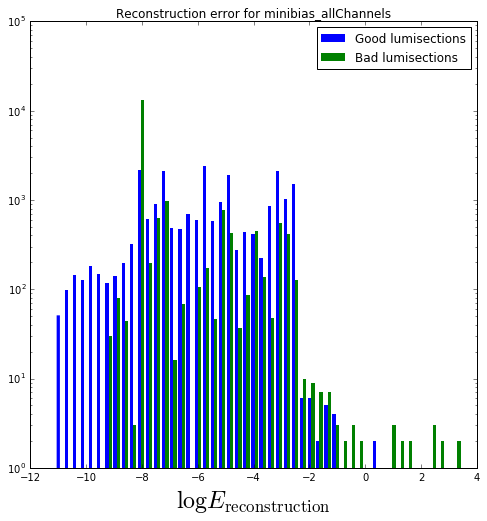

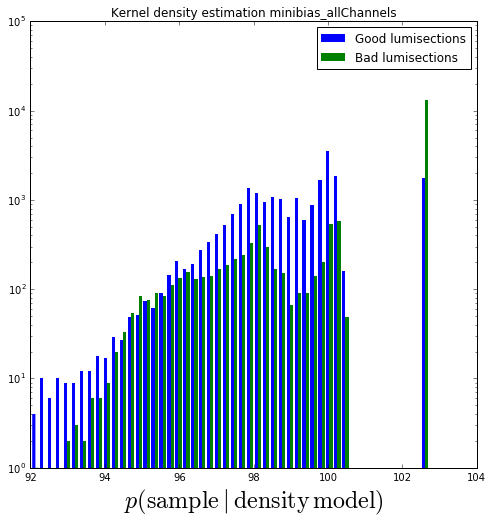

Feature group muons_muons
Mean field estimation error: 5.39e+01
AE error: 1.39e+01


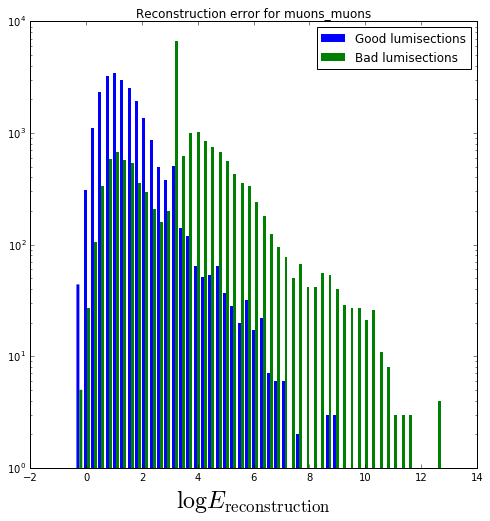

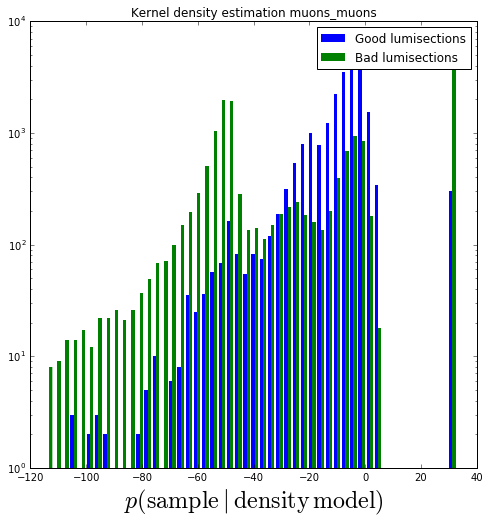

Feature group photons_muons
Mean field estimation error: 1.12e+02
AE error: 5.00e+01


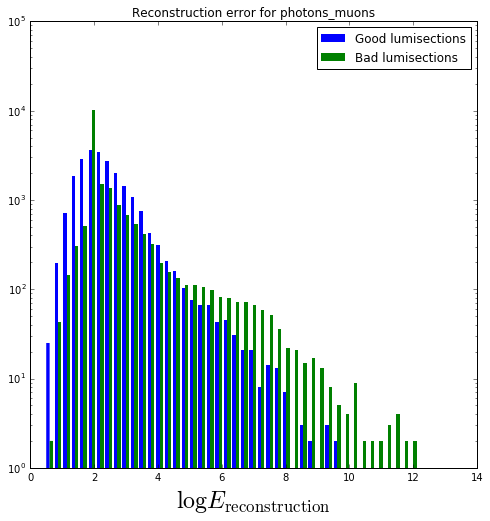

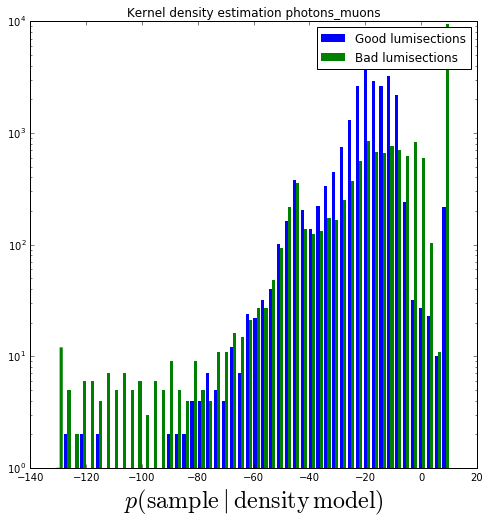

Feature group photons_photons
Mean field estimation error: 4.90e+01
AE error: 9.38e+00


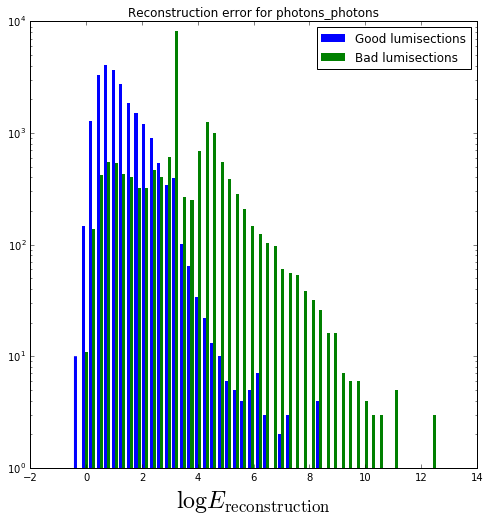

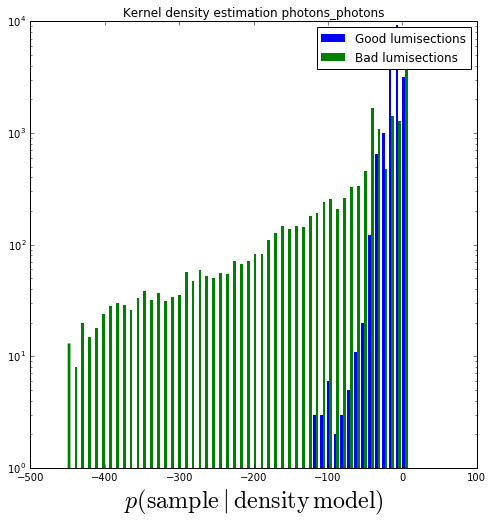

TypeError: object of type 'function' has no len()

In [60]:
for g in grouped:
    if len(g) < 1:
        continue
    X = data[grouped[g]].get_values().astype('float32')
    X_good = X[labels == 1.0]
    X_bad = X[labels == 0.0]

    ae = AE(X.shape[1], nums_units=(75, 20))
    
    for losses in ae.fit(X_good, n_epoches=128, batch_size=256, learning_rate=1.0, regularization_c=1.0e-4):
        pass
    
    X_mean = np.mean(X_good, axis=0)
    mean_error = np.mean(np.sum((X_good - X_mean) ** 2, axis=1))
    print 'Feature group', g
    print 'Mean field estimation error: %.2e' % mean_error
    print 'AE error: %.2e' % np.mean(ae.get_error(X_good))
    
    plt.figure(figsize=(8, 8))
    plt.hist([
            np.log(ae.get_error(X_good)),
            np.log(ae.get_error(X_bad))
    ], bins=50, lw=0, log=True, label=['Good lumisections', 'Bad lumisections'])
    plt.title('Reconstruction error for %s' % g)
    plt.xlabel('$\log E_{\mathrm{reconstruction}}$', fontsize=24)
    plt.legend(loc='upper right')
    plt.show()
    
    gm = BayesianGaussianMixture(n_components=10, n_init=10)
    gm.fit(ae.encode(X_good))
    
    score_good = gm.score_samples(ae.encode(X_good))
    score_bad = gm.score_samples(ae.encode(X_bad))
    
    scores = np.hstack([score_good, score_bad])
    q_1, q_99 = np.percentile(scores, q = 1), np.percentile(scores, q = 99)
    plt.figure(figsize=(8, 8))
    plt.hist([
        score_good[(score_good >= q_1) & (score_good <= q_99)],
        score_bad[(score_bad >= q_1) & (score_bad <= q_99)]
    ], bins=50, lw=0, label=['Good lumisections', 'Bad lumisections'], log=True)

    plt.title('Kernel density estimation %s' % g)
    plt.xlabel('$p(\mathrm{sample} \mid \mathrm{density\,model})$', fontsize=24)
    plt.legend()
    plt.show()